## Erdos-Renyi Network

### Import Modules

In [1]:
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy import stats
from collections import deque
import networkx as nx

### Network Initialize

In [112]:
size = int(input("Network Size : ").strip())
mean_degree = int(input("Mean Degree : ").strip())
edge_prob = mean_degree / size * 2

Network Size : 1000000
Mean Degree : 10


### ER Network Class

In [113]:
class ERN:
    def __init__(self, size, edge_prob):
        self.size = size
        self.edge_prob = edge_prob
        self.degree = dict()
        self.adjacent = dict()
        self.num_of_links = 0
        self.largest_cluster = []
        
    def generate(self):
        nodes = [i for i in range(self.size)]
        
        for node in range(self.size):
            self.adjacent[node] = []
            self.degree[node] = 0
        
        for self.num_of_links in tqdm(range(int(self.edge_prob * self.size * (self.size - 1) / 2.0))):
            node1, node2 = random.sample(nodes, 2)
            if node2 not in self.adjacent[node1]:
                self.degree[node1] += 1
                self.adjacent[node1].append(node2)
    
    def fast_generate(self):
        link_max = int(self.edge_prob * self.size * (self.size - 1) / 2.0)
        samples = np.random.randint(low=0, high=self.size-1, size=link_max*4).reshape(-1, 2)
        print(samples.shape, link_max)
        idx_filter = (samples[:, 0] - samples[:, 1]).astype(bool)
        samples = samples[idx_filter][:link_max]
        print(samples.shape, link_max)
        samples = np.unique(samples, axis=0)
        print(samples.shape)
        
        for node in range(self.size):
            self.adjacent[node] = []
            self.degree[node] = 0
        
        for node1, node2 in tqdm(samples):
            if node2 not in self.adjacent[node1]:
                self.degree[node1] += 1
                self.adjacent[node1].append(node2)
        
    def plot_degree_dist(self):
        dat = sorted(self.degree.values(), reverse=False)
        plt.figure(figsize=(10, 6))
        sns.countplot(dat)
        plt.show()
        
    @staticmethod
    def poisson(k, lamb):
        return (lamb**k/factorial(k)) * np.exp(-lamb)
    
    @staticmethod
    def negative_log_likelihood(params, data):
        ''' better alternative using scipy '''
        return -stats.poisson.logpmf(data, params[0]).sum()
    
    def fit_poisson(self):
        dat = sorted(self.degree.values(), reverse=False)
        data = dict()
        for item in dat:
            if item in data.keys():
                data[item] += 1
            else:
                data[item] = 1
                
        plt.figure(figsize=(10, 6))
        
        x_data = np.array(list(data.keys()))
        y_data = np.array(list(data.values()))
        
        result = minimize(self.negative_log_likelihood,  # function to minimize
                  x0=np.ones(1),               # start value
                  args=(dat, ),             # additional arguments for function
                  method='Powell',             # minimization method, see docs
                  )
        # result is a scipy optimize result object, the fit parameters 
        # are stored in result.x
        print(result)

        # plot poisson-distribution with fitted parameter
        x_plot = x_data
        fig = plt.figure()
        plt.bar(x_data, y_data/sum(y_data))
        plt.plot(
            x_plot,
            stats.poisson.pmf(x_data, *result.x),
            marker='o', linestyle='',
            label='Fit result',
            color='r'
        )
        plt.legend()
        plt.show()
        fig.savefig("./ern.png")
    
    def bfs2(self, start):
        # keep track of all visited nodes
        explored = []
        # keep track of nodes to be checked
        queue = [start]

        # keep looping until there are nodes still to be checked
        while queue:
            # pop shallowest node (first node) from queue
            node = queue.pop(0)
            if node not in explored:
                # add node to list of checked nodes
                explored.append(node)
                neighbours = self.adjacent[node]

                # add neighbours of node to queue
                for neighbour in neighbours:
                    queue.append(neighbour)
        return explored
    
    def bfs(self, root):
        visited = []
        queue = deque([root])

        while queue:
            n = queue.popleft()
            if n not in visited:
                visited.append(n)
                queue += set(self.adjacent[n]) - set(visited)
        return visited
    
    def bfs3(self, root):
        visited = []
        buf = self.adjacent[root]
        
        while buf:
            n = buf.pop(0)
            
            if n not in visited:
                visited.append(n)
                buf += list(set(self.adjacent[n]) - set(visited))
                
        return visited
    
    def burning(self):
        max_length = 0
        for node in tqdm(range(self.size)):
            buf = self.bfs3(node)
            if len(buf) > max_length:
                max_length = len(buf)
                self.largest_cluster = buf     

In [114]:
ern = ERN(size, edge_prob)

In [115]:
ern.fast_generate()

(19999980, 2) 9999990
(9999990, 2) 9999990
(9999944, 2)


100%|████████████████████████████████████████████████████| 9999944/9999944 [00:48<00:00, 204858.12it/s]


   direc: array([[0.00462553]])
     fun: 2561325.232641729
 message: 'Optimization terminated successfully.'
    nfev: 38
     nit: 2
  status: 0
 success: True
       x: array([9.99994407])


<Figure size 720x432 with 0 Axes>

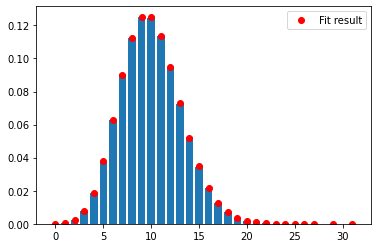

In [116]:
ern.fit_poisson()

In [111]:
ern.degree[0]

4

In [100]:
ern.adjacent[0]

[4066, 37859, 52153, 61205, 79844]